In [1]:
import pandas as pd
import numpy as np
import torch
import torch.functional as F
import torch.nn as nn 
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from torch.utils.data import Dataset, random_split, DataLoader, WeightedRandomSampler
import os
from torch.utils.tensorboard import SummaryWriter
import time
import pickle
from imblearn.over_sampling import SMOTE, ADASYN

### 1. Data Loading

In [ ]:
def read_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    X_train = data["X_train"].copy()
    X_valid = data["X_valid"].copy()
    X_test = data["X_test"].copy()
    y_train = data["y_train"].copy()
    y_valid = data["y_valid"].copy()
    y_test = data["y_test"].copy()
    features = data['feature_selection'].copy()
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, features

data_path = 'Preprocessing/Final_data.pkl'
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)

### 2. Create Dataset

In [16]:
class myDataSet(Dataset):
    def __init__(self, data, label):
        super().__init__()
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.label = torch.tensor(label.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [22]:
BATCH_SIZE = 16

train_data = myDataSet(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_data = myDataSet(X_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

test_data = myDataSet(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### 3. Define Neural Network Structure

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),       
            nn.LeakyReLU(0.1),
            
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),          

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(512, output_dim),
            nn.LogSoftmax(dim=1)      
        )
    
    def forward(self, x):
        return self.net(x)


### 4. Parameters & Hyperparameters

In [24]:
# Parameter
IN_DIM = X_train.shape[1]
OUT_DIM = 2

# Hyperparameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100


### 5. Model Training

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork(input_dim=IN_DIM, output_dim=OUT_DIM).to(device)

# class_counts = np.bincount(y_train)  
# class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
# class_weights = class_weights / class_weights.sum() 
# class_weights = class_weights.to(device)

class_weights = torch.tensor([0.3, 0.7], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)  
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

best_acc = 0.0
best_roc_auc = 0.0
    

def train(NUM_EPOCHS = 100, seed = 42):
    torch.random.manual_seed(seed)
    timestamp = int(time.time())
    n_features = X_train.shape[1]
    save_dir = f'Models/NeuralNetwork__{n_features}_features__{timestamp}/'
    os.makedirs(save_dir, exist_ok=True)
    log_dir = f'runs/NeuralNetwork__{n_features}_features__{timestamp}/'
    
    writer = SummaryWriter(log_dir=log_dir)    
    
    global best_acc, best_roc_auc

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            
            loss = criterion(preds, y)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_pred = []
        
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                y_pred.extend(preds.argmax(dim=1).tolist())
                
        avg_loss = total_loss / len(train_loader)
        
        acc_score = accuracy_score(y_valid, y_pred)
        roc_auc = roc_auc_score(y_valid, y_pred)

        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.add_scalar("Accuracy/valid", acc_score, epoch)
        writer.add_scalar("F1-Score/valid", roc_auc, epoch)

        print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Accuracy = {acc_score:.4f}, ROC-AUC Score = {roc_auc:.4f}")

        if acc_score > best_acc:
            best_acc = acc_score
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_accuracy.pth'))
            
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            torch.save(model.state_dict(),os.path.join(save_dir, 'best_roc_auc.pth'))

    torch.save(model.state_dict(), os.path.join(save_dir, 'final_epoch.pth'))
    
    print(f"Training finished. Best Accuracy: {best_acc:.4f}, Best ROC-AUC Score: {best_roc_auc:.4f}")
    
    writer.close()

In [8]:
train(100, 42)

Epoch 1: Loss = 0.6258, Accuracy = 0.8299, ROC-AUC Score = 0.6301
Epoch 2: Loss = 0.5618, Accuracy = 0.8299, ROC-AUC Score = 0.6636
Epoch 3: Loss = 0.5324, Accuracy = 0.8299, ROC-AUC Score = 0.6636
Epoch 4: Loss = 0.5388, Accuracy = 0.8163, ROC-AUC Score = 0.6555
Epoch 5: Loss = 0.5355, Accuracy = 0.8163, ROC-AUC Score = 0.6723
Epoch 6: Loss = 0.5275, Accuracy = 0.8299, ROC-AUC Score = 0.6972
Epoch 7: Loss = 0.5348, Accuracy = 0.8367, ROC-AUC Score = 0.7180
Epoch 8: Loss = 0.5087, Accuracy = 0.8503, ROC-AUC Score = 0.7429
Epoch 9: Loss = 0.4976, Accuracy = 0.8571, ROC-AUC Score = 0.7302
Epoch 10: Loss = 0.5062, Accuracy = 0.8435, ROC-AUC Score = 0.7053
Epoch 11: Loss = 0.5014, Accuracy = 0.8571, ROC-AUC Score = 0.7470
Epoch 12: Loss = 0.4818, Accuracy = 0.8163, ROC-AUC Score = 0.7393
Epoch 13: Loss = 0.4931, Accuracy = 0.8503, ROC-AUC Score = 0.7597
Epoch 14: Loss = 0.4922, Accuracy = 0.8571, ROC-AUC Score = 0.7637
Epoch 15: Loss = 0.4864, Accuracy = 0.8435, ROC-AUC Score = 0.7221
Epoc

### 6. Model Evaluation

#### 6.1. 30 Features

Accuracy score: 0.8163, ROC-AUC Score: 0.6078


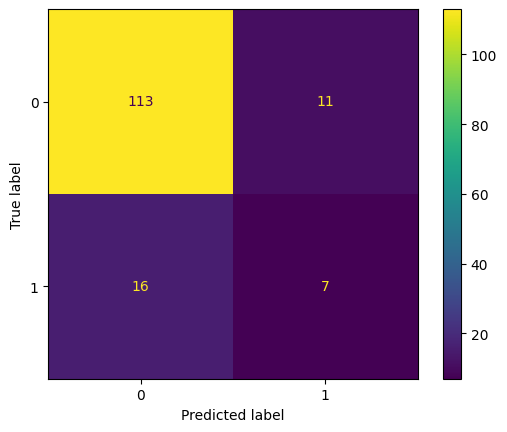

In [ ]:
model = NeuralNetwork(input_dim=30, output_dim=2).to(device)
model.load_state_dict(torch.load('Models/NeuralNetwork__30_features__1744091785/best_accuracy.pth'))

model.eval()
y_pred = []
with torch.no_grad():
    loader = test_loader
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        y_pred.extend(preds.argmax(dim=1).tolist())
        
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}, ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

#### 6.2. 25 Features

Thực hiện huấn luyện lại sau khi loại bỏ một số đặc trưng không quan trọng

In [ ]:
# for X in [X_train, X_valid, X_test]:
#     X.drop(columns = ['Education', 'EducationField', 'Department', 'Gender', 'PerformanceRating'], inplace=True)

# BATCH_SIZE = 16

# train_data = myDataSet(X_train, y_train)
# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# valid_data = myDataSet(X_valid, y_valid)
# valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

# test_data = myDataSet(X_test, y_test)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# train(100, 42)

Accuracy score: 0.8367, ROC-AUC Score: 0.6730


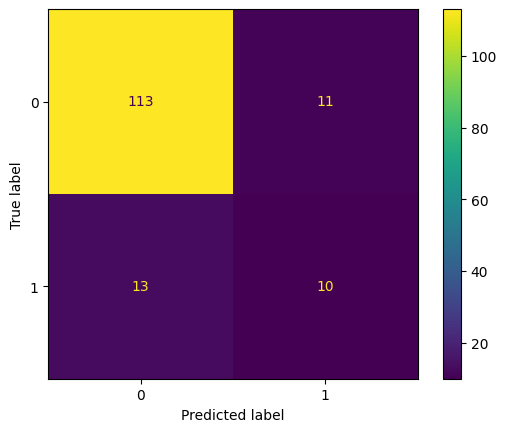

In [11]:
model = NeuralNetwork(input_dim=25, output_dim=2).to(device)
model.load_state_dict(torch.load('Models/NeuralNetwork__25_features__1744126185/best_accuracy.pth'))

model.eval()
y_pred = []
with torch.no_grad():
    loader = test_loader
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        y_pred.extend(preds.argmax(dim=1).tolist())
        
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}, ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()